Research Question: What information do open-text student reviews provide beyond numerical ratings, and can text analysis identify actionable feedback that ratings alone cannot capture?

The dataset used in this project will be a publicly available data set from Huggingface, you can access the dataset from this link: https://huggingface.co/datasets/ZephyrUtopia/ratemyprofessors_reviews

GenAI tools were used as a learning source, ideation, improvement in code as well as to improve the visualization. If needed I will be able to explain all the code that is present there in this notebook.

Load the dataset from Hugging Face

In [53]:
!pip install datasets
from datasets import load_dataset
#Load the dataset from the site of Hugging Face
dataset = load_dataset("ZephyrUtopia/ratemyprofessors_reviews")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 336239
    })
    test: Dataset({
        features: ['name', 'text', 'rating', 'difficulty', 'date'],
        num_rows: 144103
    })
})


Convert the dataset to pandas array

In [54]:
import pandas as pd
#as pandas array
df = pd.concat(
    [dataset[split].to_pandas() for split in dataset.keys()],
    ignore_index=True
)
print(df.columns)
print(df.shape)

Index(['name', 'text', 'rating', 'difficulty', 'date'], dtype='object')
(480342, 5)


Some basic printing functions to see some of the observations

In [55]:
#Don't get confused with the output, in some of the cases when pandas cannot squeeze data, it divides
#the data in the way as shows in the output
print(df)
print(df["text"].head())
print(df["rating"].value_counts())
print(df["rating"].describe()) #rating is still not numeric, so this does not give too much information
print(df.describe())
print(pd.to_numeric(df["rating"], errors = "coerce").describe()) #converting rating to numerical value coerce will assign
#NaN value to missing or invalid data, also here describe will give all the parameters it gives for numericals

                        name  \
0               Leila Hawana   
1              Gloria Magana   
2          Teresa Canganelli   
3                Kumar Ankit   
4               Irina Garces   
...                      ...   
480337        Crystal Koenig   
480338        Karen Caldwell   
480339        Andrew Hudnall   
480340  David-James Gonzalez   
480341          Tyler Vouros   

                                                     text rating difficulty  \
0       Although the homework is not too much, they ar...    4.0        5.0   
1       Where can I start she's a very tough grader. H...    1.0        5.0   
2       She is a wonderful professor! Very interactive...    5.0        4.0   
3       Study solutions had incorrect answers taken fr...    1.0        4.0   
4       Super nice and helpful. Was always there in of...    5.0        4.0   
...                                                   ...    ...        ...   
480337  Amazing! Dr. Koenig gives the best lectures of...    5

Add some demo of the plots using seaborn

In [56]:
%pip install seaborn
%pip install matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Bar chart for frequency count of each of the ratings

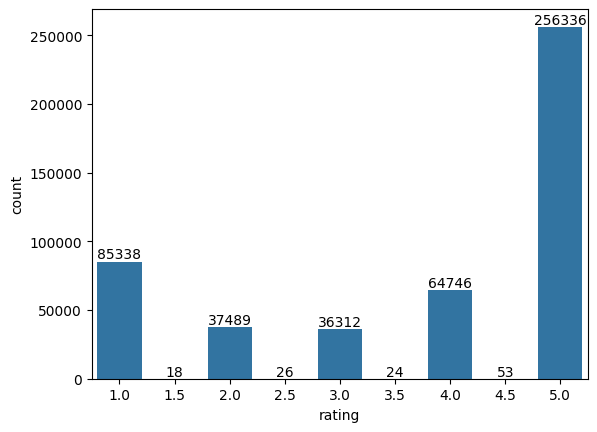

In [57]:
#Ratings are ordered in ascending order
ax = sns.countplot(
    data=df,
    x="rating",
    order=sorted(df["rating"].dropna().unique())
)
#Add frequency labels on top of each bar
#In matplot/seaborn, bars are store in "containers", so this loop goes to every bar in iterations
for container in ax.containers:
    ax.bar_label(container)
#Display the plot, in jupyter notebook this graph is shown even without the following line, but it might not be the case for .py or
#other coding environments, so writing the following line ensures portability
plt.show()


Make a new dataset that has rating as numerical rather than string

In [58]:
#Make a new dataset df_num where we'll make changes to the dataset df and have numerical values for rating
df_num = df.copy()
df_num["rating"] = pd.to_numeric(df["rating"], errors = "coerce")

#Sanity checks (better than printing the entire dataframe)
print(df_num["rating"].dtype)
print(df_num.shape)

float64
(480342, 5)


Remove the observations with rating as 1.5, 2.5, 3.5 or 4.5

In [59]:
#Check the divisibility of the dating by 1, if its not divisible by 1 
#(if its a float with some value after the decimal) remove those observations
df_num = df_num[df_num["rating"] % 1 == 0]
df_num = df_num.reset_index(drop=True)

#Sanity checks
print(df_num.shape)
print(df_num["rating"].value_counts().sort_index())

(480221, 5)
rating
1.0     85338
2.0     37489
3.0     36312
4.0     64746
5.0    256336
Name: count, dtype: int64


## Completing Data Construction & Measurement

Now we'll complete the data cleaning, create comprehensive descriptive statistics, and prepare the dataset for modeling.

In [60]:
# Check for missing values in our cleaned dataset
print("Missing values in cleaned dataset:")
print(df_num.isnull().sum())

# Check for duplicate reviews
duplicates = df_num.duplicated(subset=['text']).sum()
print(f"Number of duplicate reviews (based on text): {duplicates}")
print(f"Percentage of duplicates: {(duplicates/len(df_num)*100):.2f}%")
df_clean = df_num.copy()

Missing values in cleaned dataset:
name          0
text          0
rating        0
difficulty    0
date          0
dtype: int64
Number of duplicate reviews (based on text): 0
Percentage of duplicates: 0.00%


### Text Cleaning and Preprocessing
We'll clean the review text by handling basic issues like extra whitespace, but preserve meaningful content.

In [61]:
import re

def clean_text(text):
    # Handle missing or empty values
    if pd.isna(text) or text == '':
        return ''

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove punctuation (so "class." -> "class")
    # Keeps letters, numbers, underscores, and spaces
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace (tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing whitespace
    text = text.strip()

    return text


# Apply text cleaning
df_clean['text_cleaned'] = df_clean['text'].apply(clean_text)


In [62]:
# Calculate word count for each review
df_clean['word_count'] = df_clean['text_cleaned'].apply(lambda x: len(x.split()))

# Calculate character count
df_clean['char_count'] = df_clean['text_cleaned'].apply(len)

print("Text statistics:")
print(df_clean[['word_count', 'char_count']].describe())

# Identify very short reviews (less than 5 words)
short_reviews = df_clean[df_clean['word_count'] < 5]
print(f"\nReviews with less than 5 words: {len(short_reviews)} ({len(short_reviews)/len(df_clean)*100:.2f}%)")

Text statistics:
          word_count     char_count
count  480221.000000  480221.000000
mean       47.453362     255.687232
std        17.776241      93.831220
min         0.000000       0.000000
25%        36.000000     194.000000
50%        54.000000     298.000000
75%        61.000000     333.000000
max        87.000000     492.000000

Reviews with less than 5 words: 7362 (1.53%)


In [63]:
# Remove reviews with less than 5 words (too short to be meaningful)
df_clean = df_clean[df_clean['word_count'] >= 5].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"Dataset size after removing short reviews: {len(df_clean)}")
print(f"\nFinal cleaned dataset shape: {df_clean.shape}")
print(f"Total reviews removed from original: {len(df_num) - len(df_clean)}")

Dataset size after removing short reviews: 472859

Final cleaned dataset shape: (472859, 8)
Total reviews removed from original: 7362


In [64]:
# Convert date column to datetime
df_clean['date_parsed'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Extract year and month
df_clean['year'] = df_clean['date_parsed'].dt.year
df_clean['month'] = df_clean['date_parsed'].dt.month

# Check date parsing results
print("Date parsing results:")
print(f"Successfully parsed dates: {df_clean['date_parsed'].notna().sum()}")
print(f"Failed to parse: {df_clean['date_parsed'].isna().sum()}")
print(f"\nYear range: {df_clean['year'].min()} to {df_clean['year'].max()}")

Date parsing results:
Successfully parsed dates: 472859
Failed to parse: 0

Year range: 2003 to 2024


In [65]:
# Create binary target: 1 for positive (4-5), 0 for negative (1-2)
# Remove neutral reviews (3)

# Guessing the exact rating might be difficult because of the dominance of rating of 5, because of which we'll be working on 
# identifying if the comment is positive or negative and to remove the ambiguity created by the rating of 3, we'll remove the 
# rating of 3

df_modeling = df_clean[df_clean['rating'] != 3.0].copy()

df_modeling['sentiment'] = df_modeling['rating'].apply(
    lambda x: 1 if x >= 4 else 0
)

# Map to labels for clarity
df_modeling['sentiment_label'] = df_modeling['sentiment'].map({
    0: 'Negative',
    1: 'Positive'
})

print(f"Dataset size after removing neutral reviews: {len(df_modeling)}")
print(f"\nClass distribution:")
print(df_modeling['sentiment_label'].value_counts())
print(f"\nClass distribution (%):")
print(df_modeling['sentiment_label'].value_counts(normalize=True) * 100)
# Normalize converts the data to the proportion of the whole available data, so, multiplying by 100 gives percentage

Dataset size after removing neutral reviews: 436836

Class distribution:
sentiment_label
Positive    316271
Negative    120565
Name: count, dtype: int64

Class distribution (%):
sentiment_label
Positive    72.400397
Negative    27.599603
Name: proportion, dtype: float64


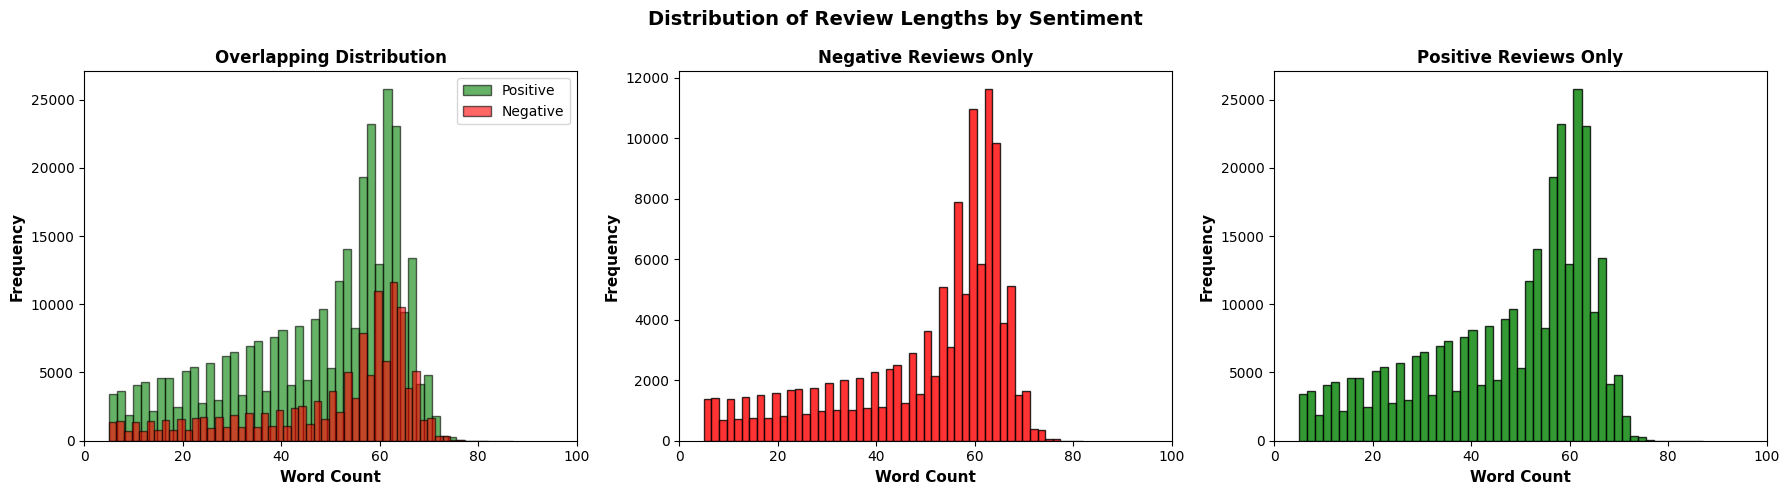

Word count statistics by sentiment:

NEGATIVE REVIEWS:
count    120565.000000
mean         49.710082
std          17.027085
min           5.000000
25%          40.000000
50%          57.000000
75%          62.000000
max          82.000000
Name: word_count, dtype: float64

POSITIVE REVIEWS:
count    316271.000000
mean         47.137834
std          17.093259
min           5.000000
25%          35.000000
50%          53.000000
75%          61.000000
max          87.000000
Name: word_count, dtype: float64


In [66]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Overlapping histograms with TRANSPARENCY

axes[0].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.6, label='Positive', color='green', edgecolor='black')
axes[0].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.6, label='Negative', color='red', edgecolor='black')
axes[0].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Overlapping Distribution', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].set_xlim(0, 100)
#set_xlim helps to keep the reviews with length 0 to 100 and ignore other outliers that is way beyond 100 words.

# Plot 2: Separate histograms
axes[1].hist(df_modeling[df_modeling['sentiment']==0]['word_count'], 
             bins=50, alpha=0.8, color='red', edgecolor='black')
axes[1].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Negative Reviews Only', fontsize=12, fontweight='bold')
axes[1].set_xlim(0, 100)

axes[2].hist(df_modeling[df_modeling['sentiment']==1]['word_count'], 
             bins=50, alpha=0.8, color='green', edgecolor='black')
axes[2].set_xlabel('Word Count', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[2].set_title('Positive Reviews Only', fontsize=12, fontweight='bold')
axes[2].set_xlim(0, 100)

plt.suptitle('Distribution of Review Lengths by Sentiment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistics
print("Word count statistics by sentiment:")
print("\nNEGATIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==0]['word_count'].describe())
print("\nPOSITIVE REVIEWS:")
print(df_modeling[df_modeling['sentiment']==1]['word_count'].describe())

/var/folders/mg/bhg2988s5fq125xdwn5j_0nh0000gn/T/ipykernel_77098/3561641859.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data_to_plot,


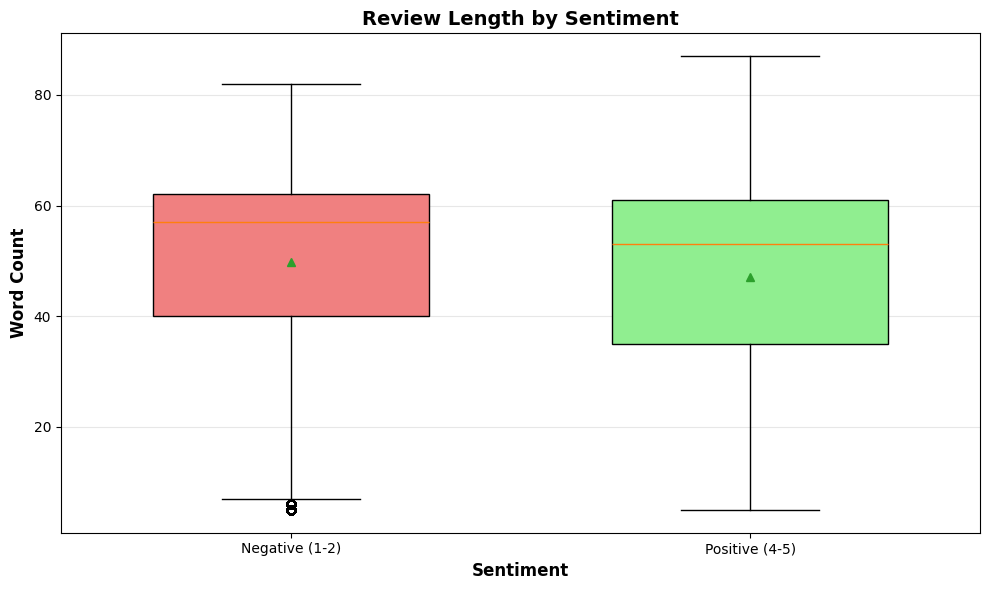

Negative median: 57.0
Positive median: 53.0


In [67]:
# box plot
plt.figure(figsize=(10, 6))

data_to_plot = [
    df_modeling[df_modeling['sentiment']==0]['word_count'],
    df_modeling[df_modeling['sentiment']==1]['word_count']
]

bp = plt.boxplot(data_to_plot, 
                 labels=['Negative (1-2)', 'Positive (4-5)'],
                 patch_artist=True, 
                 widths=0.6,
                 showmeans=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightcoral')
bp['boxes'][1].set_facecolor('lightgreen')

plt.ylabel('Word Count', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12, fontweight='bold')
plt.title('Review Length by Sentiment', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Statistics
print("Negative median:", df_modeling[df_modeling['sentiment']==0]['word_count'].median())
print("Positive median:", df_modeling[df_modeling['sentiment']==1]['word_count'].median())

## Word Frequency Analysis

In [68]:
!pip install scikit-learn

## Word Frequency Analysis

In [69]:
# Word Frequency Analysis (Using sklearn stopwords)
!pip install scikit-learn
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Use sklearn's built-in stopwords (no download needed!)
stop_words = ENGLISH_STOP_WORDS

def get_word_frequencies(texts, top_n=20):
    all_words = []
    for text in texts:
        if pd.isna(text): # We don't really need this because we have already cleared the ones with NaN and None, but its a good practice
            continue
        words = str(text).split()
        # Filter out stopwords and very short words
        words = [w for w in words if w not in stop_words and len(w) > 2] # This will help to remove stop words and super small words
        all_words.extend(words)
    
    return Counter(all_words).most_common(top_n)

# Get top words for positive and negative reviews
print("Analyzing word frequencies...")
positive_reviews = df_modeling[df_modeling['sentiment']==1]['text_cleaned']
negative_reviews = df_modeling[df_modeling['sentiment']==0]['text_cleaned']

top_positive = get_word_frequencies(positive_reviews, 20)
top_negative = get_word_frequencies(negative_reviews, 20)

print("TOP 20 WORDS IN POSITIVE REVIEWS (4-5 stars)")
for i, (word, count) in enumerate(top_positive, 1):
    print(f"{i:2d}. {word:.<25} {count:>8,} occurrences")

print("TOP 20 WORDS IN NEGATIVE REVIEWS (1-2 stars)")
for i, (word, count) in enumerate(top_negative, 1):
    print(f"{i:2d}. {word:.<25} {count:>8,} occurrences")


Analyzing word frequencies...
TOP 20 WORDS IN POSITIVE REVIEWS (4-5 stars)
 1. class....................  282,986 occurrences
 2. professor................  151,427 occurrences
 3. easy.....................   90,049 occurrences
 4. great....................   81,270 occurrences
 5. really...................   77,874 occurrences
 6. students.................   77,262 occurrences
 7. lectures.................   62,858 occurrences
 8. work.....................   56,636 occurrences
 9. good.....................   54,493 occurrences
10. best.....................   52,297 occurrences
11. lot......................   51,999 occurrences
12. help.....................   45,984 occurrences
13. assignments..............   44,051 occurrences
14. gives....................   40,617 occurrences
15. course...................   40,429 occurrences
16. recommend................   39,248 occurrences
17. just.....................   39,027 occurrences
18. time.....................   37,779 occurrences
19. car

## Visualize Word Frequencies

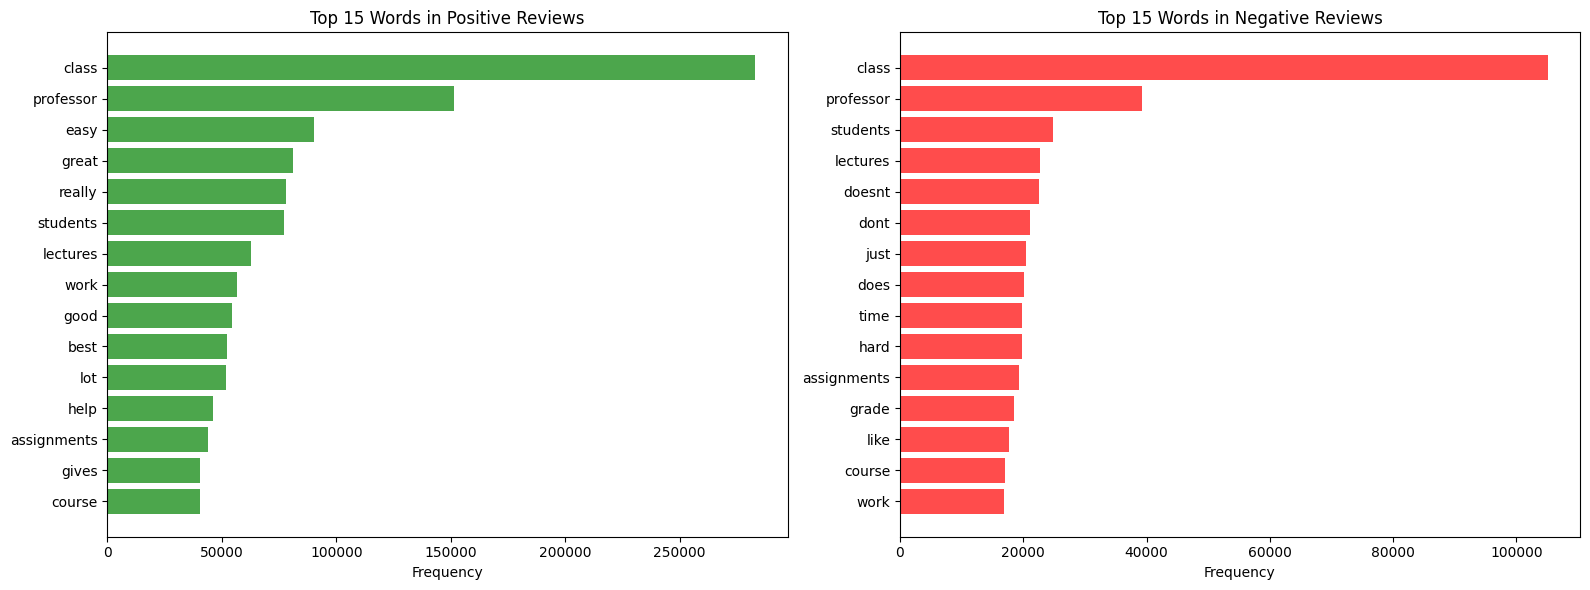

In [70]:
# Create bar plots for top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive reviews
words_pos, counts_pos = zip(*top_positive[:15])
axes[0].barh(words_pos, counts_pos, color='green', alpha=0.7)
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 15 Words in Positive Reviews')
axes[0].invert_yaxis()

# Negative reviews
words_neg, counts_neg = zip(*top_negative[:15])
axes[1].barh(words_neg, counts_neg, color='red', alpha=0.7)
axes[1].set_xlabel('Frequency')
axes[1].set_title('Top 15 Words in Negative Reviews')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Temporal Analysis - Ratings Over Time

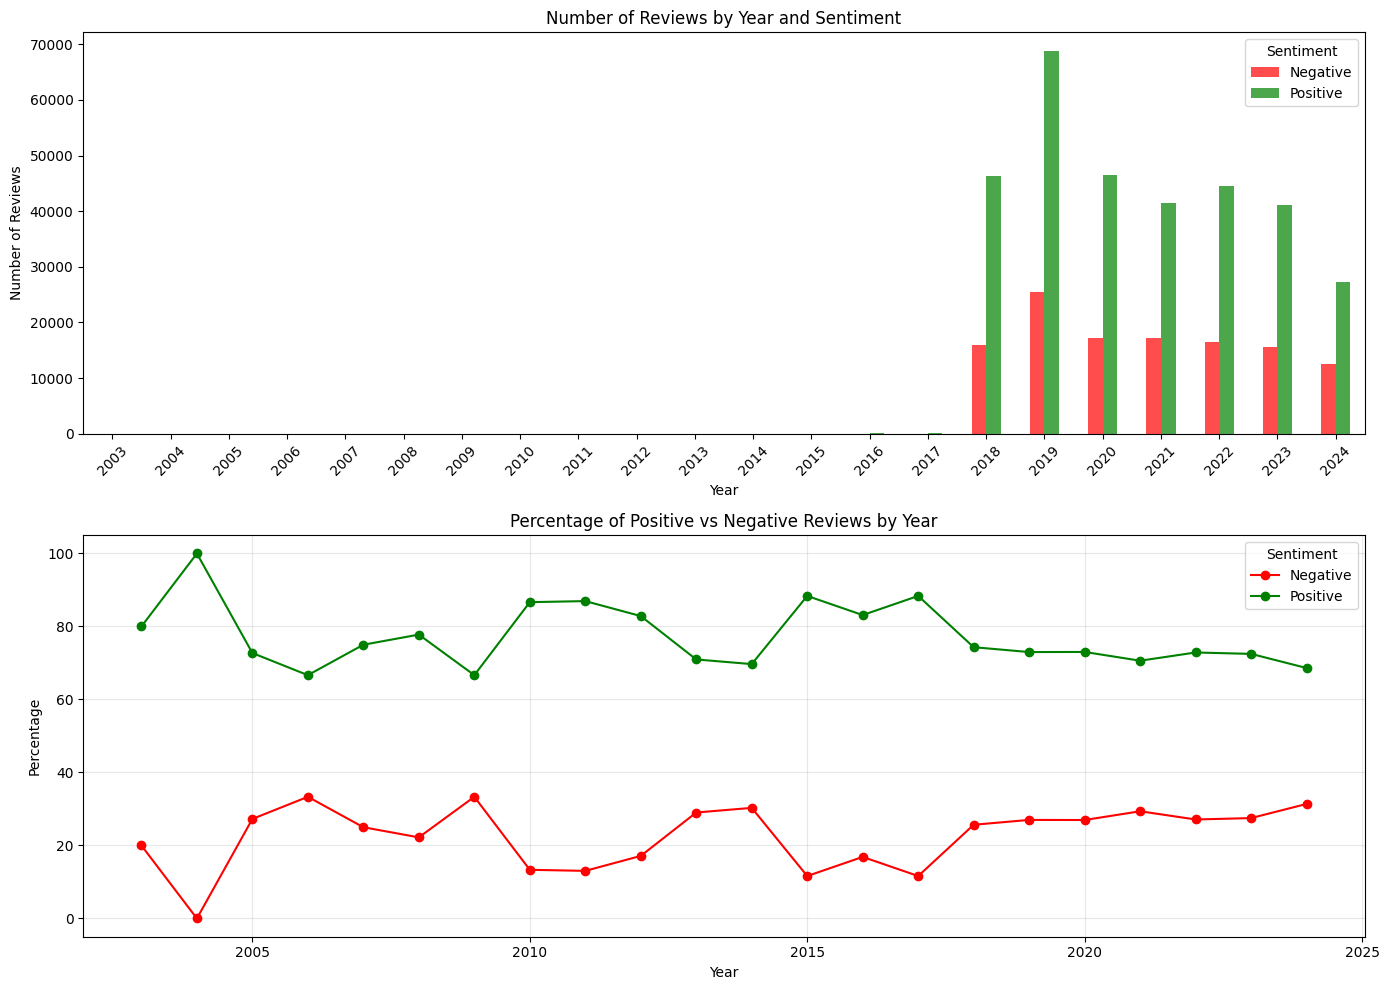

Average ratings by year:
year
2003    4.40
2004    4.33
2005    3.73
2006    3.58
2007    3.94
2008    4.00
2009    3.67
2010    4.27
2011    4.39
2012    4.20
2013    3.84
2014    3.88
2015    4.35
2016    4.22
2017    4.40
2018    3.88
2019    3.84
2020    3.85
2021    3.76
2022    3.88
2023    3.87
2024    3.72
Name: rating, dtype: float64


In [71]:
# Ratings over time
yearly_ratings = df_modeling.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)
# unstack will help convert rows to columns, if we don't do that the data would look like:
# year   sentiment_level
# 2018   0    16000
#        1    46000
# 2019   0    25000
#        1    69000

# But after using unstack it'll look like:
# sentiment_label      0      1
# year
# 2018             16000  46000
# 2019             25000  69000

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Absolute counts
yearly_ratings.plot(kind='bar', ax=axes[0], color=['red', 'green'], alpha=0.7)
axes[0].set_title('Number of Reviews by Year and Sentiment')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Reviews')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=45)

# Proportions
yearly_props = yearly_ratings.div(yearly_ratings.sum(axis=1), axis=0) * 100
yearly_props.plot(kind='line', ax=axes[1], marker='o', color=['red', 'green'])
axes[1].set_title('Percentage of Positive vs Negative Reviews by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Sentiment')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Average ratings by year:")
print(df_modeling.groupby('year')['rating'].mean().round(2))

## Difficulty vs Rating Analysis

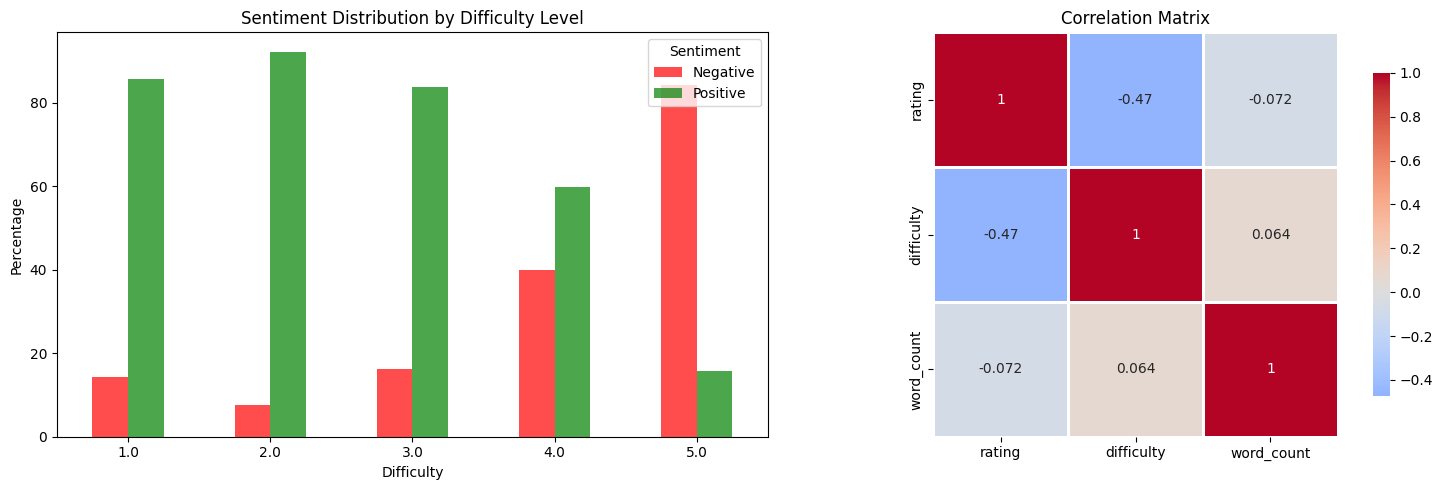


Correlation between rating and difficulty:
Pearson correlation: -0.475


In [72]:
# Difficulty vs Rating relationship
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Cross-tabulation
crosstab = pd.crosstab(df_modeling['difficulty'], df_modeling['sentiment_label'], normalize='index') * 100
crosstab.plot(kind='bar', ax=axes[0], color=['red', 'green'], alpha=0.7)
axes[0].set_title('Sentiment Distribution by Difficulty Level')
axes[0].set_xlabel('Difficulty')
axes[0].set_ylabel('Percentage')
axes[0].legend(title='Sentiment')
axes[0].tick_params(axis='x', rotation=0)

# Correlation heatmap
corr_data = df_modeling[['rating', 'difficulty', 'word_count']].corr()
# .corr() calculates the pearson correlation between each pair
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, ax=axes[1], 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()

print("\nCorrelation between rating and difficulty:")
print(f"Pearson correlation: {df_modeling[['rating', 'difficulty']].corr().iloc[0, 1]:.3f}")

## Class Imbalance Visualization

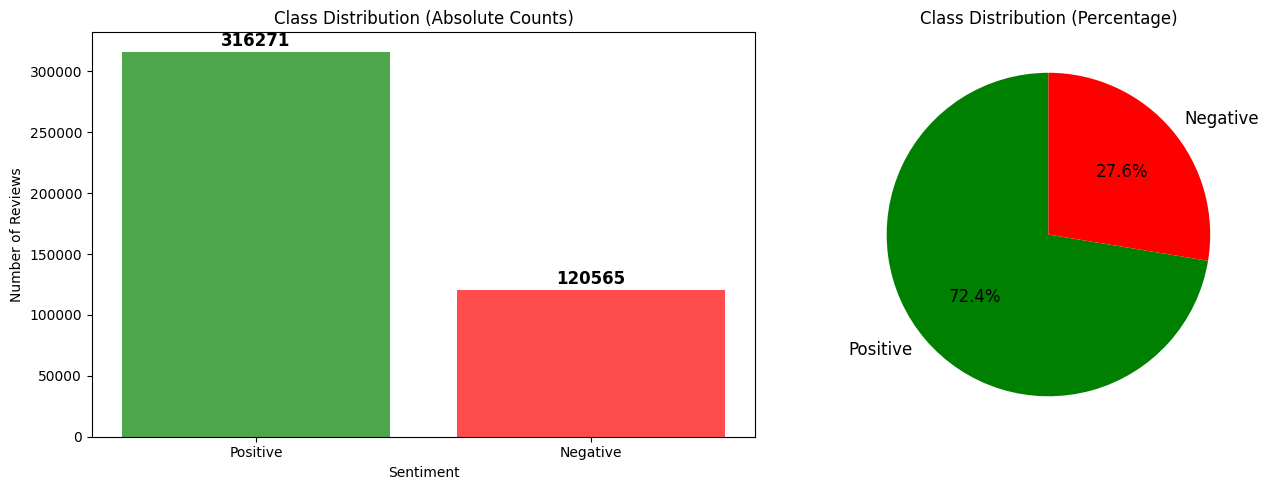

Class imbalance ratio: 2.62:1

This means we have 2.62 positive reviews
for every 1 negative review


In [73]:
# Detailed class imbalance analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sentiment_counts = df_modeling['sentiment_label'].value_counts()
axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Reviews')
for i, v in enumerate(sentiment_counts.values):
# The iteration will go for 2 cycles one when the value of sentiment_counts is 0 and the other when its 1
    axes[0].text(i, v + 5000, str(v), ha='center', fontsize=12, fontweight='bold')

# Pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90, textprops={'fontsize': 12})
# Here startangle gives the diagram the place for it to start from
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio: {sentiment_counts['Positive'] / sentiment_counts['Negative']:.2f}:1")
print(f"\nThis means we have {sentiment_counts['Positive'] / sentiment_counts['Negative']:.2f} positive reviews")
print(f"for every 1 negative review")

## Create Train-Test-Validation Splits

In [74]:

import numpy as np 
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)
# This fixes the split so that it'll be consistent for the values coming onwards

# First split: 80% train+val, 20% test
X = df_modeling['text_cleaned']
y = df_modeling['sentiment']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
# Stratify will ensure the class proportion in the original dataset is carried over to the split as well
)

# Second split: split the temp into 75% train, 25% val (of the 80%)
# This gives us 60% train, 20% val, 20% test overall
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("DATASET SPLITS")
print(f"Training set:   {len(X_train):>7,} samples ({len(X_train)/len(df_modeling)*100:>5.1f}%)")
print(f"Validation set: {len(X_val):>7,} samples ({len(X_val)/len(df_modeling)*100:>5.1f}%)")
print(f"Test set:       {len(X_test):>7,} samples ({len(X_test)/len(df_modeling)*100:>5.1f}%)")
print(f"Total:          {len(df_modeling):>7,} samples")

print("CLASS DISTRIBUTION IN EACH SET")

print("\nTraining set:")
train_dist = y_train.value_counts(normalize=True).sort_index()
for sentiment, pct in train_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("\nValidation set:")
val_dist = y_val.value_counts(normalize=True).sort_index()
for sentiment, pct in val_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("\nTest set:")
test_dist = y_test.value_counts(normalize=True).sort_index()
for sentiment, pct in test_dist.items():
    label = "Positive" if sentiment == 1 else "Negative"
    print(f"  {label}: {pct:.1%}")

print("VERIFICATION: Class distributions are balanced across all sets!")

DATASET SPLITS
Training set:   262,101 samples ( 60.0%)
Validation set:  87,367 samples ( 20.0%)
Test set:        87,368 samples ( 20.0%)
Total:          436,836 samples
CLASS DISTRIBUTION IN EACH SET

Training set:
  Negative: 27.6%
  Positive: 72.4%

Validation set:
  Negative: 27.6%
  Positive: 72.4%

Test set:
  Negative: 27.6%
  Positive: 72.4%
VERIFICATION: Class distributions are balanced across all sets!


## Save Processed Data

In [75]:
# Create a final dataframe with all our processed features
df_final = df_modeling.copy()

# Save the full processed dataset
df_final.to_csv('processed_reviews.csv', index=False)
print("Saved full processed dataset to 'processed_reviews.csv'")

# Also save the split indices for reproducibility
split_data = {
    'train_indices': X_train.index.tolist(),
    'val_indices': X_val.index.tolist(),
    'test_indices': X_test.index.tolist()
}

import json
with open('split_indices.json', 'w') as f:
    json.dump(split_data, f)
print("Saved split indices to 'split_indices.json'")


Saved full processed dataset to 'processed_reviews.csv'
Saved split indices to 'split_indices.json'


# Identify and Remove Domain-Specific Common Words

In [76]:
# Week 3, Cell 16: Remove Domain-Specific Common Words

from collections import Counter

# Get all words from both positive and negative reviews
all_words_pos = []
all_words_neg = []

for text in df_modeling[df_modeling['sentiment']==1]['text_cleaned']:
    if pd.isna(text):
        continue
    all_words_pos.extend(str(text).split())

for text in df_modeling[df_modeling['sentiment']==0]['text_cleaned']:
    if pd.isna(text):
        continue
    all_words_neg.extend(str(text).split())

# Count frequencies
pos_counter = Counter(all_words_pos)
neg_counter = Counter(all_words_neg)

# Find words that appear frequently in BOTH positive and negative
# These are domain-specific but not sentiment-bearing
common_in_both = set()
threshold = 10000  # Words appearing at least 10K times

for word in pos_counter:
    if pos_counter[word] > threshold and neg_counter.get(word, 0) > threshold:
        common_in_both.add(word)

print("Domain-specific words common in both positive and negative reviews:")
print(f"Found {len(common_in_both)} words")
print("\nExamples:", sorted(list(common_in_both))[:20])

# These words don't help distinguish sentiment, so we'll exclude them in modeling
domain_stopwords = common_in_both

# Save for later use
import json
with open('domain_stopwords.json', 'w') as f:
    json.dump(list(domain_stopwords), f)

print("\nDomain stopwords identified and saved")

Domain-specific words common in both positive and negative reviews:
Found 104 words

Examples: ['a', 'about', 'all', 'also', 'an', 'and', 'any', 'are', 'as', 'assignments', 'at', 'be', 'because', 'but', 'can', 'class', 'course', 'did', 'difficult', 'do']

Domain stopwords identified and saved


# Final Data Preparation Summary

In [77]:
print(f"\nTotal reviews: {len(df_modeling):,}")
print(f"Positive: {(df_modeling['sentiment']==1).sum():,}")
print(f"Negative: {(df_modeling['sentiment']==0).sum():,}")

print("\nText preprocessing applied:")
print("  Lowercasing")
print("  URL removal")
print("  Whitespace normalization")
print("  Short review removal (<5 words)")
print("  Domain stopword identification")
print("  Text finalized in 'text_final' column")

print("\nFeatures available:")
print(f"  text_final: Processed text for modeling")
print(f"  sentiment: Binary target (0=Negative, 1=Positive)")
print(f"  rating: Original rating (1-2 or 4-5)")
print(f"  word_count: Review length")
print(f"  difficulty: Course difficulty (1-5)")



Total reviews: 436,836
Positive: 316,271
Negative: 120,565

Text preprocessing applied:
  Lowercasing
  URL removal
  Whitespace normalization
  Short review removal (<5 words)
  Domain stopword identification
  Text finalized in 'text_final' column

Features available:
  text_final: Processed text for modeling
  sentiment: Binary target (0=Negative, 1=Positive)
  rating: Original rating (1-2 or 4-5)
  word_count: Review length
  difficulty: Course difficulty (1-5)


# Save Final Processed Data

In [78]:
# Week 3, Cell: Create text_final column and Save

# Create text_final column (using cleaned text without lemmatization)
df_modeling['text_final'] = df_modeling['text_cleaned']

print("Created 'text_final' column")

# Check which columns exist
print("\nAvailable columns:")
print(df_modeling.columns.tolist())

# Save only columns that exist
essential_cols = ['text_final', 'sentiment', 'rating', 'word_count']

# Add difficulty only if it exists
if 'difficulty' in df_modeling.columns:
    essential_cols.append('difficulty')

df_to_save = df_modeling[essential_cols].copy()

# Save with compression
# Save to Assets folder
import os
os.makedirs('../Assets', exist_ok=True)

df_to_save.to_csv('../Assets/processed_reviews.csv.gz', index=False, compression='gzip')

# Save split indices
split_data = {
    'train_indices': X_train.index.tolist(),
    'val_indices': X_val.index.tolist(),
    'test_indices': X_test.index.tolist()
}

import json
with open('../Assets/split_indices.json', 'w') as f:
    json.dump(split_data, f)

# Save domain stopwords if you created them
if 'domain_stopwords' in locals():
    with open('../Assets/domain_stopwords.json', 'w') as f:
        json.dump(list(domain_stopwords), f)
    print("Saved: domain_stopwords.json")

import os
file_size = os.path.getsize('../Assets/processed_reviews.csv.gz') / (1024 * 1024)

print(f"Saved: processed_reviews.csv.gz ({file_size:.2f} MB)")
print(f"Saved: split_indices.json")
print(f"Total reviews: {len(df_modeling):,}")
print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")

Created 'text_final' column

Available columns:
['name', 'text', 'rating', 'difficulty', 'date', 'text_cleaned', 'word_count', 'char_count', 'date_parsed', 'year', 'month', 'sentiment', 'sentiment_label', 'text_final']
Saved: domain_stopwords.json
Saved: processed_reviews.csv.gz (35.99 MB)
Saved: split_indices.json
Total reviews: 436,836
Train: 262,101 | Val: 87,367 | Test: 87,368
